## 001_simple_v1

This run uses a very simple model to get a rough idea for how difficult the problem is.

In [64]:
import sys
sys.path.append('../')
sys.path.append('../../../')
# keras expects data to be encoded in a particular way, to_categorical does this encoding for us (one-hot encoding)
from keras.utils.np_utils import to_categorical
import libs.importing as importing
import pandas as pd
import os
import libs.render as render 
import models
import libs.analysis as analysis
import libs.normalization as normalization
from importlib import reload
import libs.data_prep as data_prep
import numpy as np

In [4]:
# LOAD PATCH DATA REFERENCES

# directory setup
data_source = '../6ceac90d'
train_dir = os.path.join(data_source, 'train')
test_dir = os.path.join(data_source, 'test')
val_dir = os.path.join(data_source, 'val')

# get references to the data we want
train_patches_df = pd.read_csv(os.path.join(train_dir, 'patches_cleaned.csv'))
train_data_reader = importing.PatchDataReader(os.path.join(train_dir, 'patches'), train_patches_df)

test_patches_df = pd.read_csv(os.path.join(test_dir, 'patches_cleaned.csv'))
test_data_reader = importing.PatchDataReader(os.path.join(test_dir, 'patches'), test_patches_df)

val_patches_df = pd.read_csv(os.path.join(val_dir, 'patches_cleaned.csv'))
val_data_reader = importing.PatchDataReader(os.path.join(val_dir, 'patches'), val_patches_df)

In [5]:
## READ PATCH DATA

# load train, test, and validation data
x_train, y_train = train_data_reader.read_data()
x_test, y_test = test_data_reader.read_data()
x_val, y_val = val_data_reader.read_data()

# LOG RESULTS
## Visualize the patches
data_prep.log_patch_data_reader(train_dir, train_data_reader)
data_prep.log_patch_data_reader(test_dir, test_data_reader)
data_prep.log_patch_data_reader(val_dir, val_data_reader)

In [38]:
# OPTIONAL: shuffle the data randomly
x_train2, y_train2 = data_prep.shuffle_two_arrays(x_train, y_train)
x_test2, y_test2 = data_prep.shuffle_two_arrays(x_test, y_test)
x_val2, y_val2 = data_prep.shuffle_two_arrays(x_val, y_val)

In [39]:
## CONVERT CLASSES TO KERAS FORMAT
# keras expects classes to be number from 0-N, we are using 1-N numbering so we need to convert.
# then we also have to change the classes to one-hot encoding

y_train_oh = to_categorical(y_train2 - 1)
y_test_oh  = to_categorical(y_test2 - 1)
y_val_oh   = to_categorical(y_val2 - 1)

In [40]:
# NORMALIZATION

m, std = normalization.dataset_mean_and_std(x_train2)

x_train = (x_train2 - m) / std
x_test  = (x_test2 - m) / std
x_val   = (x_val2 - m) / std

In [41]:
## MODEL : load from file, show summary, and compile
reload(models)

model = models.shallow_model_v1()
display(model.summary())

# parameters:
learning_rate = 1e-3

model.compile(optimizer = 'adam', loss = "binary_crossentropy", metrics=["accuracy"])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
activation_6 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 64)        0         
__________

None

In [42]:
reload(data_prep)

data_prep.check_for_nans(x_train2)
data_prep.check_for_nans(x_test2)
data_prep.check_for_nans(x_val2)

print(y_train2[:20], y_test2[:20], y_val2[:20])

[1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 2 1 1] [2 2 1 1 2 2 1 2 1 2 1 1 2 1 2 1 1 1 1 1] [1 2 1 2 1 1 1 2 1 2 2 2 2 1 1 2 1 2 1 1]


In [45]:
## RUN!!!

# parameters
batch_size = 16
epochs = 5

history = model.fit(x_train2,y_train_oh, batch_size=batch_size,
                              epochs = epochs,
                              validation_data = (x_test2,y_test_oh), shuffle=True,
                              verbose = 1, callbacks=[models.annealer()])

Train on 891 samples, validate on 298 samples
Epoch 1/5
891/891 [==============================] - 32s 36ms/step - loss: 0.3029 - acc: 0.8788 - val_loss: 0.6552 - val_acc: 0.8591
Epoch 2/5
891/891 [==============================] - 31s 35ms/step - loss: 0.2530 - acc: 0.8962 - val_loss: 0.5368 - val_acc: 0.8540
Epoch 3/5
891/891 [==============================] - 34s 38ms/step - loss: 0.2229 - acc: 0.9052 - val_loss: 0.9100 - val_acc: 0.8473
Epoch 4/5
891/891 [==============================] - 34s 38ms/step - loss: 0.2018 - acc: 0.9169 - val_loss: 1.1480 - val_acc: 0.8406
Epoch 5/5
891/891 [==============================] - 34s 38ms/step - loss: 0.2001 - acc: 0.9186 - val_loss: 0.6078 - val_acc: 0.8540

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


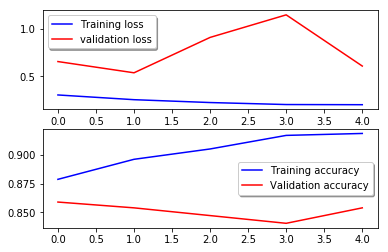

In [50]:
render.plot_training_and_validation_curves(history)

In [46]:
## Second RUN!!! : increase the epochs to 15

history2 = model.fit(x_train2,y_train_oh, batch_size=16,
                              epochs = 15,
                              validation_data = (x_test2,y_test_oh), shuffle=True,
                              verbose = 1, callbacks=[models.annealer()])

Train on 891 samples, validate on 298 samples
Epoch 1/15
891/891 [==============================] - 34s 38ms/step - loss: 0.1508 - acc: 0.9405 - val_loss: 1.0781 - val_acc: 0.8456
Epoch 2/15
891/891 [==============================] - 34s 38ms/step - loss: 0.1398 - acc: 0.9444 - val_loss: 0.9037 - val_acc: 0.8574
Epoch 3/15
891/891 [==============================] - 34s 38ms/step - loss: 0.1277 - acc: 0.9523 - val_loss: 1.1757 - val_acc: 0.8507
Epoch 4/15
891/891 [==============================] - 34s 38ms/step - loss: 0.1077 - acc: 0.9557 - val_loss: 1.5335 - val_acc: 0.8171
Epoch 5/15
891/891 [==============================] - 32s 36ms/step - loss: 0.1072 - acc: 0.9596 - val_loss: 1.1315 - val_acc: 0.8674
Epoch 6/15
891/891 [==============================] - 33s 37ms/step - loss: 0.0770 - acc: 0.9703 - val_loss: 1.5492 - val_acc: 0.8389
Epoch 7/15
891/891 [==============================] - 33s 38ms/step - loss: 0.0631 - acc: 0.9764 - val_loss: 1.8093 - val_acc: 0.8037
Epoch 8/15
891/8

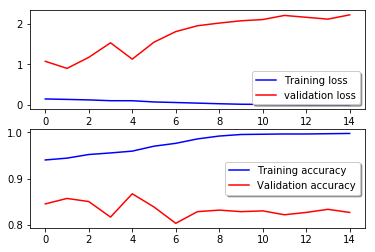

Precision (specificity): 57.274%
Recall (sensitivity): 56.176%
Accuracy: 57.500%
F1: 55.099%


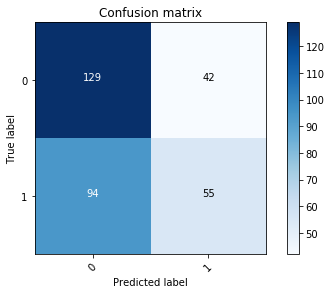

In [65]:

reload(render)
render.plot_training_and_validation_curves(history2)

y_pred_oh = model.predict(x_val2)

cm = render.setup_confusion_matrix(y_pred_oh, x_val2, y_val_oh)

render.plot_confusion_matrix(cm, num_classes=2)

scores = analysis.get_scores_oh(y_val_oh, y_pred_oh)
analysis.print_scores(scores)